In [145]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

plt.style.use('ggplot')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [146]:
customers = joblib.load('data/customers_clean.pkl')
checkouts = joblib.load('data/checkouts_clean.pkl')
books = joblib.load('data/books_clean.pkl')
libraries = joblib.load('data/libraries_clean.pkl')

In [147]:
return_deadline = 28

checkouts['days_return'] = (checkouts['date_returned']-checkouts['date_checkout']).dt.days
checkouts['late'] = checkouts['days_return']>return_deadline

## Late Return Aggregated Analysis
---

In [148]:
print(f"Late returns total: {100*sum(checkouts['late'])/len(checkouts):.2f}%")

Late returns total: 6.91%


array([[<Axes: title={'center': 'days_return'}>]], dtype=object)

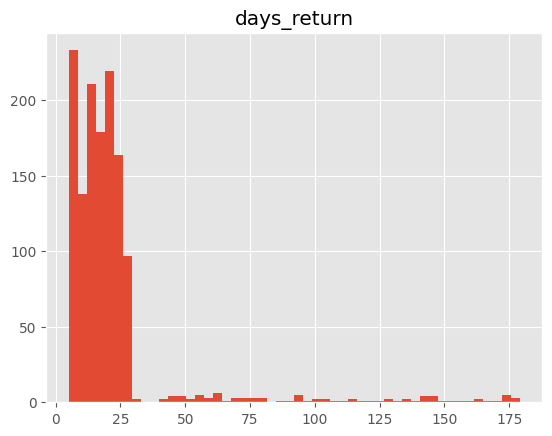

In [149]:
checkouts.hist('days_return', bins=50)

## Effect of Book Characteristics

Let's start with analyzing how book features affect late returns.

In [162]:
df_merged = checkouts.merge(books, on='id').merge(customers, left_on='patron_id', right_on='id', suffixes=('', '_patron'))
df_merged['book_age'] = (df_merged['date_checkout']-df_merged['publishedDate']).dt.days/365.25

In [163]:
min(df_merged['book_age'])

-2.6803559206023273

Since there are books that have 'publishedDate' in the future, their age will be replaced by the median value from other books.

In [164]:
df_merged.loc[df_merged['book_age']<0, 'book_age'] = df_merged.loc[df_merged['book_age']>0, 'book_age'].median()

<Axes: title={'center': 'book_age'}, xlabel='late'>

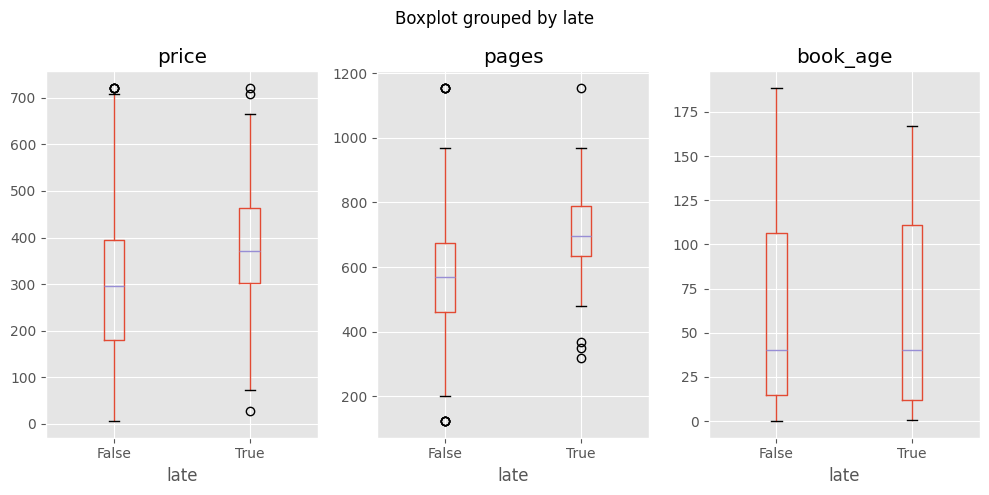

In [165]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5), tight_layout=True)
df_merged.boxplot(column='price', by='late', ax=ax[0])
df_merged.boxplot(column='pages', by='late', ax=ax[1])
df_merged.boxplot(column='book_age', by='late', ax=ax[2])

In [166]:
print(df_merged['price'].corr(df_merged['pages']))

0.7535197390155827


* More expensive books seem to be returned late more often. This might be due to correlation with number of pages.
* Longer books are more likely to be returned late, probaly due to patrons needing more time to read them.
    * The library might adjust the return period by book length to avoid penalizing slow readers 
* Book age seems to have no effect on late returns

<Axes: ylabel='categories'>

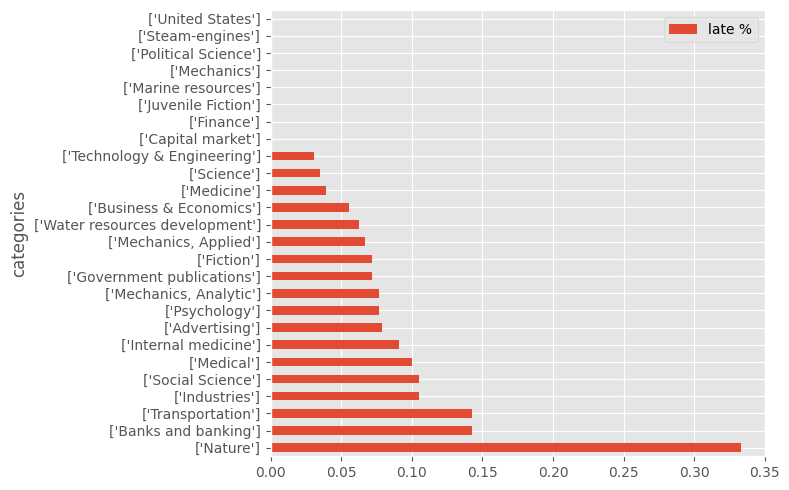

In [214]:
category_list = (tmp:=df_merged['categories'].value_counts())[tmp>10].index.to_list()
# Excluding categories with too few books
pivot_category = pd.DataFrame(df_merged[df_merged['categories'].isin(category_list)&(df_merged['late']==True)].groupby(['categories'], dropna=False)['id'].count()/
                          df_merged[df_merged['categories'].isin(category_list)].groupby(['categories'], dropna=False)['id'].count()).reset_index().sort_values('id', ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 5), tight_layout=True)
pivot_category.plot.barh('categories', 'id', ax=ax, width=0.5, label='late %')

Books from the 'Nature' category are most likely to be returned late.

## Effect of Patron Characteristics

Next step is to analyze how do patrons who return late differ from those that don't.

In [167]:
df_merged['patron_age'] = (df_merged['date_checkout']-df_merged['birth_date']).dt.days/365.25
df_merged.head(1)

,id,patron_id,library_id,date_checkout,date_returned,days_return,late,title,authors,publisher,publishedDate,categories,price,pages,id_patron,name,street_address,city,state,zipcode,birth_date,gender,education,occupation,book_age,patron_age
0,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,2018-05-29,2018-06-12,14,False,Indian Financial System 5E,['Khan'],Tata McGraw-Hill Education,2006-06-01,NaN,416.99,752,8d3f63e1deed89d7ba1bf6a4eb101373,jeanette nelms,4942 se 28th ave,portland,oregon,97202.0,1965-01-24,female,graduate degree,tech,11.991786,53.341547


<Axes: xlabel='patron_age', ylabel='pages'>

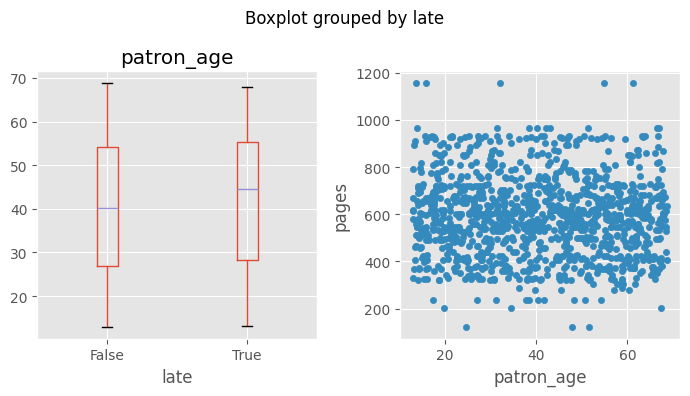

In [168]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4), tight_layout=True)
df_merged.boxplot(column='patron_age', by='late', ax=ax[0])
df_merged.plot.scatter('patron_age', 'pages', ax=ax[1])

Older patrons are silghtly more likely to return books late. They are not reading longer books, so this can't explain the difference.

<Axes: ylabel='state'>

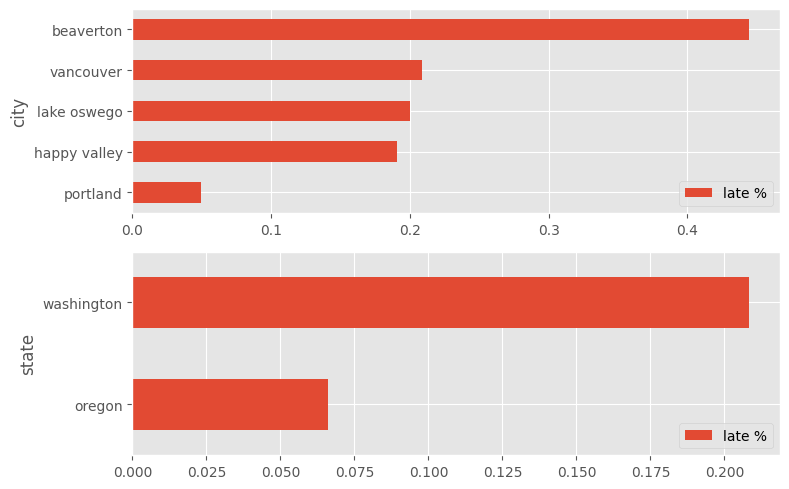

In [215]:
city_list = (tmp:=df_merged['city'].value_counts())[tmp>10].index.to_list()
# Excluding cities with too few customers
pivot_city = pd.DataFrame(df_merged[df_merged['city'].isin(city_list)&(df_merged['late']==True)].groupby(['city'])['id'].count()/
                          df_merged[df_merged['city'].isin(city_list)].groupby(['city'])['id'].count()).reset_index().sort_values('id')

fig, ax = plt.subplots(2, 1, figsize=(8, 5), tight_layout=True)
pivot_city.plot.barh('city', 'id', ax=ax[0], width=0.5, label='late %')

pivot_state = pd.DataFrame(df_merged[df_merged['late']==True].groupby(['state'])['id'].count()/
                          df_merged.groupby(['state'])['id'].count()).reset_index().sort_values('id')

pivot_state.plot.barh('state', 'id', ax=ax[1], width=0.5, label='late %')

Customers from outside Portland are more likely to return books late. The libraries in analysis are in Portland, so the additional trip might be one of the reasons for late returns.

<Axes: ylabel='education'>

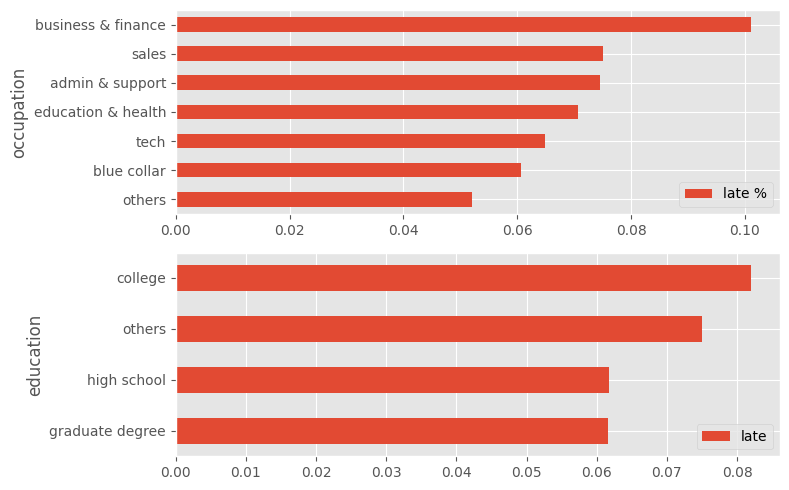

In [216]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5), tight_layout=True)

pivot_occupation = pd.DataFrame(df_merged[df_merged['late']==True].groupby(['occupation'])['id'].count()/
                          df_merged.groupby(['occupation'])['id'].count()).reset_index().sort_values('id')

pivot_occupation.plot.barh('occupation', 'id', ax=ax[0], width=0.5, label='late %')

pivot_education = pd.DataFrame(df_merged[df_merged['late']==True].groupby(['education'])['id'].count()/
                          df_merged.groupby(['education'])['id'].count()).reset_index().sort_values('id')

pivot_education.plot.barh('education', 'id', ax=ax[1], width=0.5, label='late')

Differences in education and occupation aren't extreme. Patrons working in business and finance are a bit more likely to return late.

## Library Characteristics

In [171]:
df_merged = df_merged.merge(libraries, left_on='library_id', right_on='id', suffixes=('', '_library'))

In [186]:
df_merged['name_library'].value_counts()

name_library
multnomah county library                      141
multnomah county library woodstock             84
multnomah county library holgate               82
multnomah county library capitol hill          81
multnomah county library sellwood moreland     81
multnomah county library central               79
multnomah county library midland               78
multnomah county library belmont               77
multnomah county library north portland        77
multnomah county library kenton                76
multnomah county library gregory heights       75
multnomah county library albina                72
multnomah county library hollywood library     72
multnomah county library hillsdale             71
friends of the multnomah county library        65
multnomah county library northwest             63
multnomah county library st johns              57
Name: count, dtype: int64

<Axes: ylabel='name_library'>

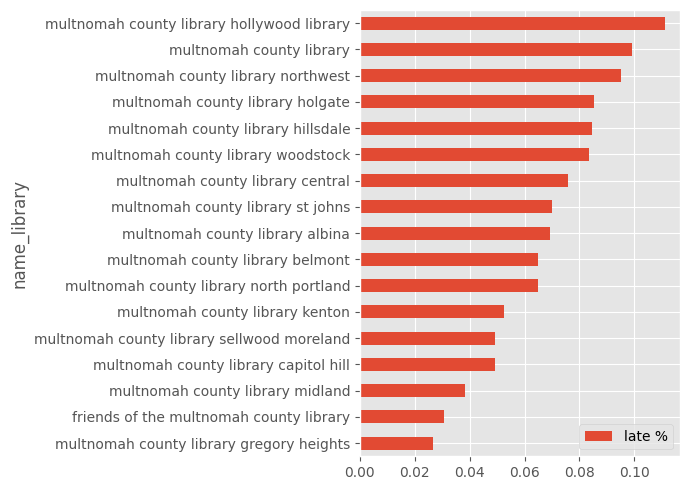

In [217]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), tight_layout=True)

pivot_library = pd.DataFrame(df_merged[df_merged['late']==True].groupby(['name_library'])['id'].count()/
                          df_merged.groupby(['name_library'])['id'].count()).reset_index().sort_values('id')

pivot_library.plot.barh('name_library', 'id', ax=ax, width=0.5, label='late %')

Some libraries stand out with lower on-time returns. This might be caused by their opening times, distance from public transportation and parking lots, etc.